# Optimization Problem


# Optimization Problem

The optimization problem can be written as:

$$
\text{min} \quad \sum_{t} \left( r x_t + q u_t \right)
$$

Subject to the following constraints:

$$
u_t + k s_t = G_t \quad \forall t \quad \text{(Demand constraint)}
$$

$$
c_{t+1} = c_t + s_t \quad \forall t \quad \text{(Storage evolution)}
$$

$$
c_T = c_0 \quad \text{(Final charge constraint)}
$$

$$
x_{t+1} = x_t + L_t - u_t \quad \forall t \quad \text{(Workload evolution)}
$$


$$
x_T = 0 \quad \text{(Backlog clearance)}
$$

$$
x_t, c_t, u_t \geq 0 \quad \forall t \quad \text{(Non-negativity)}
$$


Where:
- \( x_t \): backlog or deferred workload at time \( t \)
- \( u_t \): amount of workload processed at time \( t \)
- \( r \): cost per unit of backlog — penalizes unprocessed/delayed work
- \( q \): cost per unit of processing — energy, labor, or other operational costs
- \( L_t \): new workload arriving at time \( t \)


## Constraints

### Demand Constraint:
$$
u_t + k s_t = G_t \quad \forall t
$$

Where:
- \( G_t \): power consumption (e.g., grid energy) at time \( t \)
- \( s_t \): power stored into battery at time \( t \)
- \( k \): conversion factor between storage and power (e.g., efficiency)

### Storage Evolution:
$$
c_{t+1} = c_t + s_t \quad \forall t
$$

### Final Charge Constraint:
$$
c_T = c_0
$$

### Workload Evolution:
$$
x_{t+1} = x_t + L_t - u_t \quad \forall t
$$

Where:
- \( L_t \): new workload arriving at time \( t \)

### Backlog Clearance:
$$
x_T = 0
$$

### Non-Negativity:
$$
x_t \geq 0, \quad c_t \geq 0, \quad u_t \geq 0 \quad \forall t
$$

## Summary
This linear program determines:
- Workload processing decisions (\( u_t \))
- Energy usage and storage (\( s_t \), \( c_t \))
- Backlog management (\( x_t \))

All while minimizing the total cost from both deferred (\( r x_t \)) and completed work (\( q u_t \)), under operational and physical constraints.


In [32]:
import pandas as pd
workload_path = "data/Workload/GoogleClusteData_CPU_Data_Hourly_1.csv"
renewable_path = "data/CarbonIntensity/CAISO_NG_&_avgCI.csv"
workload = pd.read_csv(workload_path)
renewable_gen = pd.read_csv(renewable_path)
workload.head()
Load = workload["cpu_load"]*100
caiso_wind_cap = 6284
DC_wind_cap = 120
Carbon_intensity = renewable_gen["avg_CI"].to_list()
caiso_wind_gen = renewable_gen["WND"]
DC_wind_gen = (caiso_wind_gen/caiso_wind_cap)*DC_wind_cap
T = 5
# G = DC_wind_gen.round()
G = DC_wind_gen.fillna(0).astype(int).to_list()
G[:T]

Carbon_intensity

[222.29592090536,
 260.9175830341113,
 271.89088207780776,
 280.02771987154205,
 284.6616378045201,
 287.57890514102326,
 280.33146141649047,
 269.2246846718449,
 261.1452428037794,
 260.0289423444063,
 274.42876526458616,
 286.8540877325924,
 289.3288237828522,
 294.15132526039463,
 304.87827388376155,
 302.5240910906912,
 199.00041293874744,
 148.32072794571252,
 145.80705097665555,
 134.1341209598433,
 134.88647551070636,
 137.13066535117468,
 157.4505657577444,
 194.43947675489773,
 242.0412507437033,
 301.50954380072767,
 317.2053556578145,
 312.0121833191005,
 317.1525292293009,
 333.4113773550393,
 341.9138765117759,
 346.44645196882976,
 346.0643681456526,
 335.12607876981014,
 344.52997601918463,
 342.15049145122657,
 338.4177359103459,
 332.0477823867262,
 331.01816271389976,
 327.19370943584624,
 222.3781081436653,
 160.1298663227017,
 140.2701855868884,
 142.81536632672214,
 148.45188544449277,
 147.21450863002357,
 148.11743364521672,
 167.38400789733464,
 240.006843455945

In [33]:
G = [10, 8, 6, 7, 5]
L = [6, 7, 8, 5, 4]



# Added an extra 0 to make 1500, to test for bugs and we realized that we had an equality constraint where it should be inequality
# And the objective function was slightly off, check version history to see how we changed it!

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Input data (already loaded from previous context)
# Parameters
q = 1.0  # Cost per unit energy used
r = 200  # Cost per unit backlog
k = 1  # Storage energy conversion factor
computing_limit =100 # float("inf") #or switch to actual computing limit
battery_limit = 300 # float("inf") # or switch to actual computing limit
# Generation (G_t) over 10 time steps (e.g., hours of the day)
# G = [30, 40, 50, 60, 75, 90, 100, 80, 60, 40]  # Peak generation occurs midday and early evening

# # Load (L_t) over the same 10 time steps
# L = [35, 45, 50, 55, 70, 85, 90, 80, 65, 40]  # Load peaks during evening hours
L = [
    30, 25, 20, 20, 25, 35, 50, 60, 65, 60, 55, 50, 
    55, 65, 75, 85, 90, 95, 90, 70, 60, 50, 40, 35
]  # Computational Load sum = 1400
G = [
     0, 0, 0, 0, 7, 21, 50, 86, 114, 129, 143, 150,
   143, 122, 86, 57, 29, 14, 7, 0, 0, 0, 0, 0
]  #Renewable Generation sum = 1526

T = len(G)


C = Carbon_intensity[:T]  # Carbon intensity in gCO2/kWh

# Plotting helper function for each scenario
def plot_results(title, served, soc=None, second_plot=None, backlog=None,
                 carbon_intensity=None, emissions=None):
    
    
    total_demand = sum(L)
    total_served = sum(served)
    total_emissions = sum(emissions) if emissions else None

    # Collect secondary plots
    secondary_plots = []
    if second_plot: secondary_plots.append(('Generation Over Time', G, 'Power (kW)', 'green'))
    if soc: secondary_plots.append(('Battery State of Charge', soc, 'Stored Energy', 'purple'))
    if backlog: secondary_plots.append(('Backlog Over Time', backlog, 'Energy', 'crimson'))
    if carbon_intensity: secondary_plots.append(('Carbon Intensity Over Time', carbon_intensity, 'kg CO₂ / MWh', 'gray'))
    if emissions: secondary_plots.append(('Emissions Over Time', emissions, 'kg CO₂', 'black'))
    
    num_rows = 1 + len(secondary_plots)

    fig, axs = plt.subplots(num_rows, 1, figsize=(10, 4 * num_rows), squeeze=False)

    # Plot 1: Load and Served
    ax_main = axs[0, 0]
    ax_main.plot(range(len(L)), L, marker="o", label="Load (Demand)", color="blue")
    ax_main.plot(range(len(served)), served, marker="o", label="Served", color="orange")
    ax_main.fill_between(range(len(L)), 0, L, alpha=0.1, color="blue")
    ax_main.fill_between(range(len(served)), 0, served, alpha=0.2, color="orange")
    ax_main.set_title(title)
    ax_main.set_xlabel("Time Step")
    ax_main.set_ylabel("Energy")
    ax_main.grid(True)
    ax_main.legend()

    text = f"Total Demand = {total_demand:.1f}\nTotal Served = {total_served:.1f}"
    if total_emissions is not None:
        text += f"\nTotal Emissions = {total_emissions:.1f} kgCO₂"
    ax_main.text(len(L) - 2, max(max(L), max(served)) * 0.85,
                text, bbox=dict(facecolor='white', alpha=0.7), fontsize=11)

    # Plot each additional element in its own row
    for i, (title_i, data_i, y_label, color) in enumerate(secondary_plots, start=1):
        ax = axs[i, 0]
        ax.plot(range(len(data_i)), data_i, marker='o', color=color, label=title_i)
        ax.fill_between(range(len(data_i)), 0, data_i, color=color, alpha=0.15)
        ax.set_title(title_i)
        ax.set_xlabel("Time Step")
        ax.set_ylabel(y_label)
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()
    
   





# Scenario 1, Naive: Served Load(t) = generation(t) (No scheduling, no storage)

To first understand the issue at hand, we run a simple simulation of our data center being supplied simply renewable sources. In this case, we supply as much renewable power as possible and if the load is less than renewable we stop at the load, resulting in extensive losses. And difficulty meeting load.

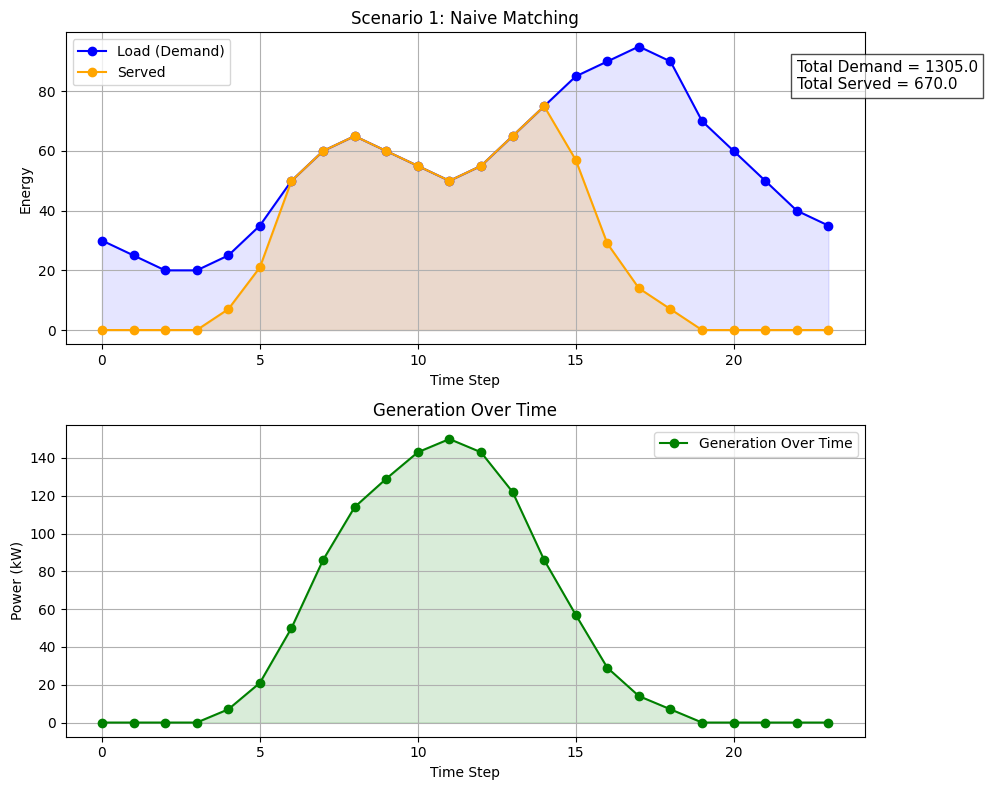

In [35]:
served_1 = [min(L[t], G[t]) for t in range(T)]
plot_results("Scenario 1: Naive Matching", served_1, second_plot=True)


# Scenario 2 — Workload Scheduling without Storage


In this implementation we have a backlog, that is incrementally built and once we have power we chip away at the power. We essentially compute as much load as the generation allows.
Cap in the total allowable computation, for capacity.

Start at 3pm for this example

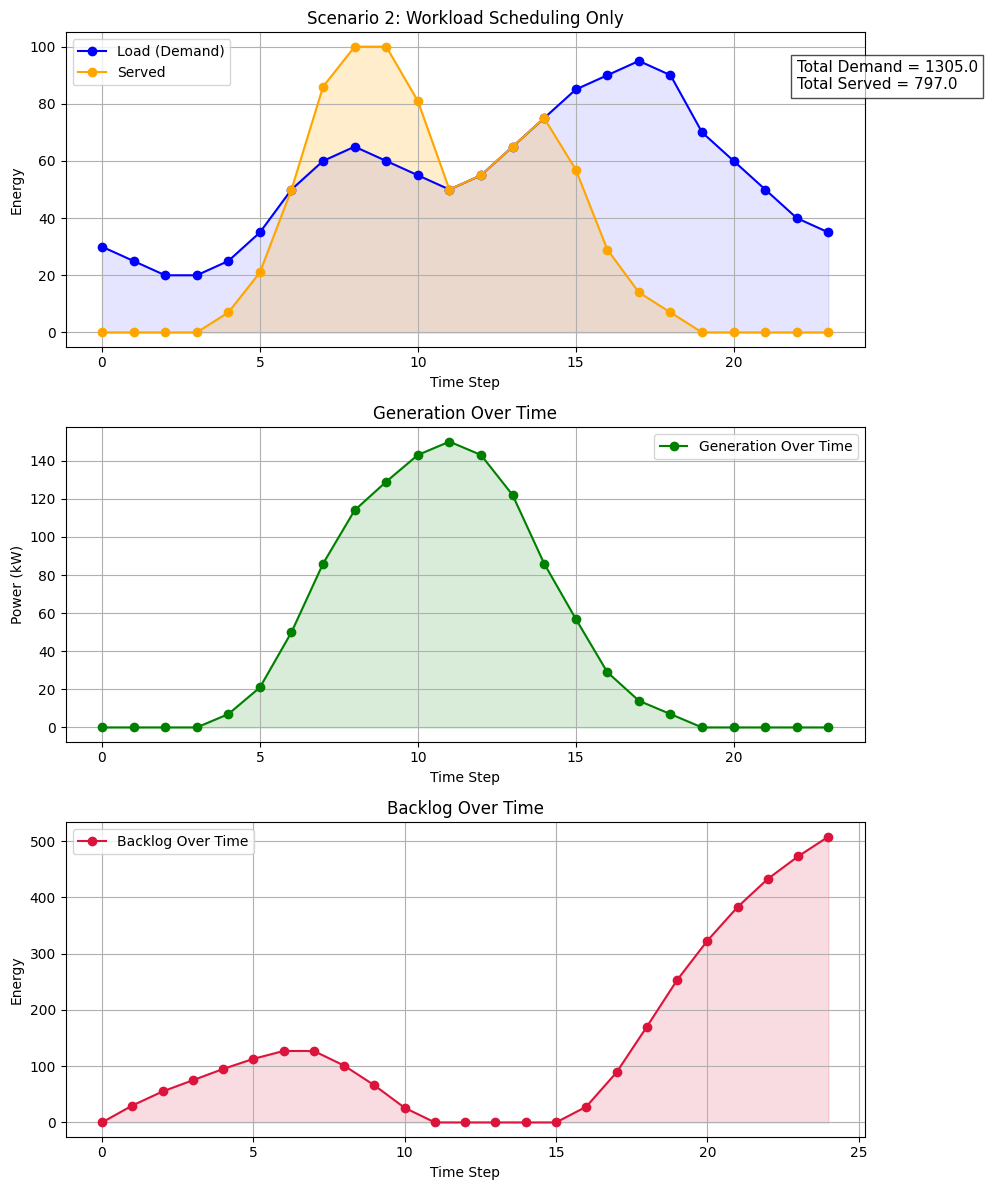

In [36]:
import gurobipy as gp
from gurobipy import GRB

# print(f"Geneartion {G}, total generation = {sum(G)}")
# print(f"Load {L}, total load = {sum(L)}")

# Model
m2 = gp.Model("workload_scheduling_no_storage")
m2.setParam('OutputFlag', 0)

# Decision variables
u = m2.addVars(T, name="u", lb=0)        # Energy used
x = m2.addVars(T+1, name="x", lb=0)      # Backlog

# Initial condition
m2.addConstr(x[0] == 0, "initial_backlog")

# Dynamics and constraints
for t in range(T):
    m2.addConstr(u[t] <= G[t], name=f"generation_limit_{t}")
    m2.addConstr(x[t+1] == x[t] + L[t] - u[t], name=f"backlog_update_{t}")
    m2.addConstr(u[t] <= computing_limit, name=f"computing limit")

# Terminal condition
m2.addConstr(x[T] >= 0, "terminal_backlog")

# Objective: Minimize backlog and energy cost (incentivizes serving more load)
m2.setObjective(gp.quicksum(r * x[t] for t in range(T+1)), GRB.MINIMIZE)

# Optimize
m2.optimize()

# Extract and plot results
if m2.status == GRB.OPTIMAL:
    served_2 = [u[t].X for t in range(T)]
    backlog_2 = [x[t].X for t in range(T+1)]  # Backlog at each time step
    plot_results("Scenario 2: Workload Scheduling Only", served_2, second_plot=True, backlog=backlog_2)


# Scenario 3: Storage, no workload scheduling

Can make the variable of start day and end day of how much storage we have

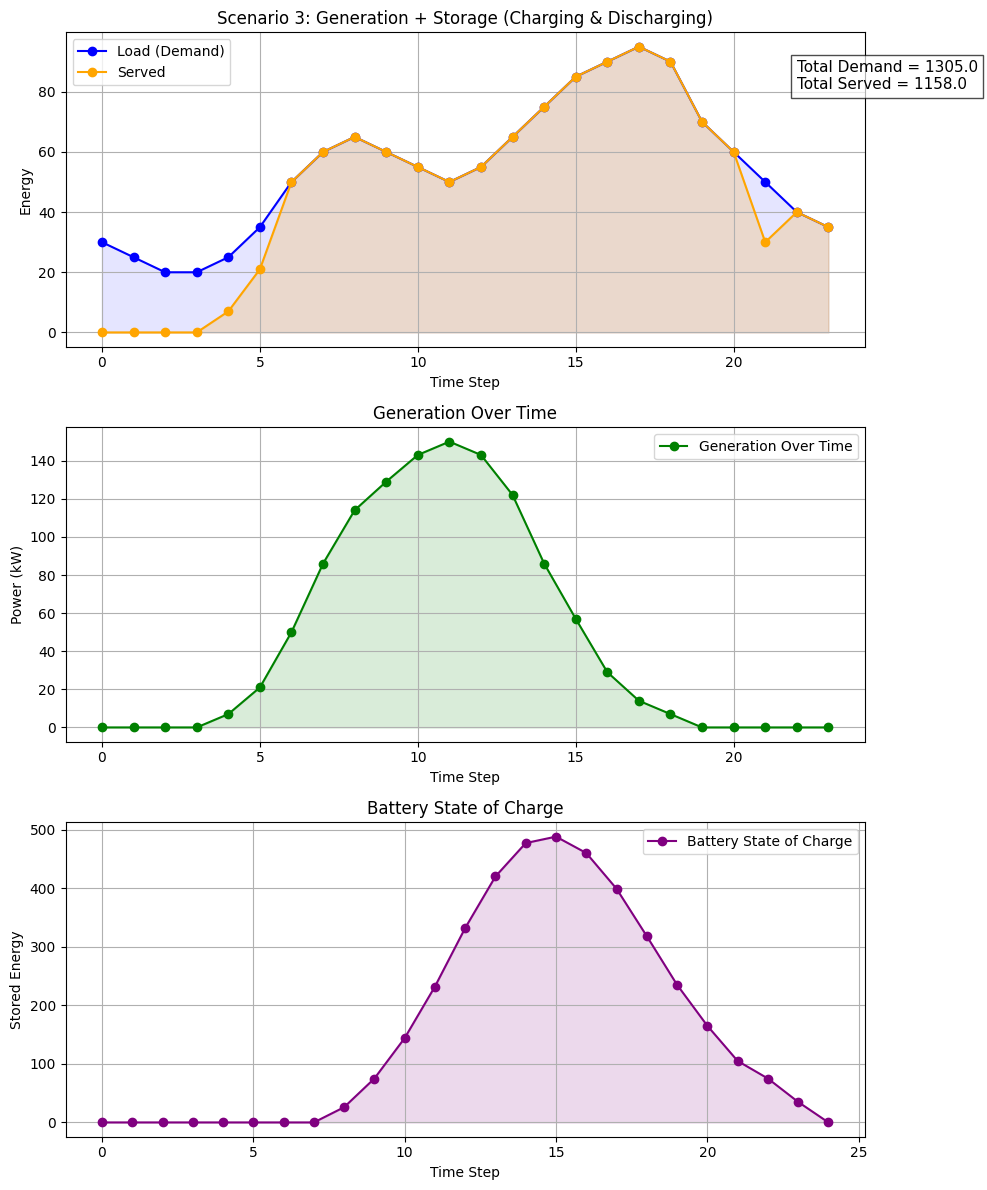

In [37]:
import gurobipy as gp
from gurobipy import GRB

# Given values


# Model
m3 = gp.Model("generation_storage_with_charging_discharging")
m3.setParam('OutputFlag', 0)


# Decision variables
u = m3.addVars(T, name="u", lb=0)              # Energy used to meet load (no negative use)
s_charge = m3.addVars(T, name="s_charge", lb=0)  # Energy charged into the storage
s_discharge = m3.addVars(T, name="s_discharge", lb=0)  # Energy discharged from storage
c = m3.addVars(T+1, name="c", lb=0)             # Battery storage level at each time step

# Initial condition for battery storage
m3.addConstr(c[0] == 0, "initial_storage")

# Constraints
for t in range(T):
    # Energy used to meet load
    m3.addConstr(u[t] <= L[t], name=f"meet_load_{t}")
    
    # Energy balance equation: G[t] = u[t] + s_charge[t] - s_discharge[t]
    m3.addConstr(u[t] + s_charge[t] - s_discharge[t] <= G[t], name=f"energy_balance_{t}")
    
    # Update storage level: c[t+1] = c[t] + s_charge[t] - s_discharge[t]
    m3.addConstr(c[t+1] == c[t] + s_charge[t] - s_discharge[t], name=f"storage_update_{t}")
    m3.addConstr(c[t]<=battery_limit, name = "storage limit")

    m3.addConstr(u[t] <= computing_limit, name=f"computing limit")


# Final condition: the battery should be empty at the end
m3.addConstr(c[T] == 0, "terminal_storage")

# Objective: minimize energy used (serving load) and energy storage transitions (charging/discharging)
m3.setObjective(gp.quicksum(q * u[t] + r * (L[t]-u[t]) for t in range(T)), GRB.MINIMIZE)

# Optimize
m3.optimize()

# Plot results
if m3.status == GRB.OPTIMAL:
    served_3 = [u[t].X for t in range(T)]  # Energy served to meet the load
    soc_3 = [c[t].X for t in range(T+1)]  # State of charge at each time step
    plot_results("Scenario 3: Generation + Storage (Charging & Discharging)", served_3, soc=soc_3, second_plot=True)


Include efficiency terms examine the trade-off between workload scheduling, finding the balance between those cost.

# scenario 4: Workload scheduling + storage


Optimal Schedule for Scenario 4:


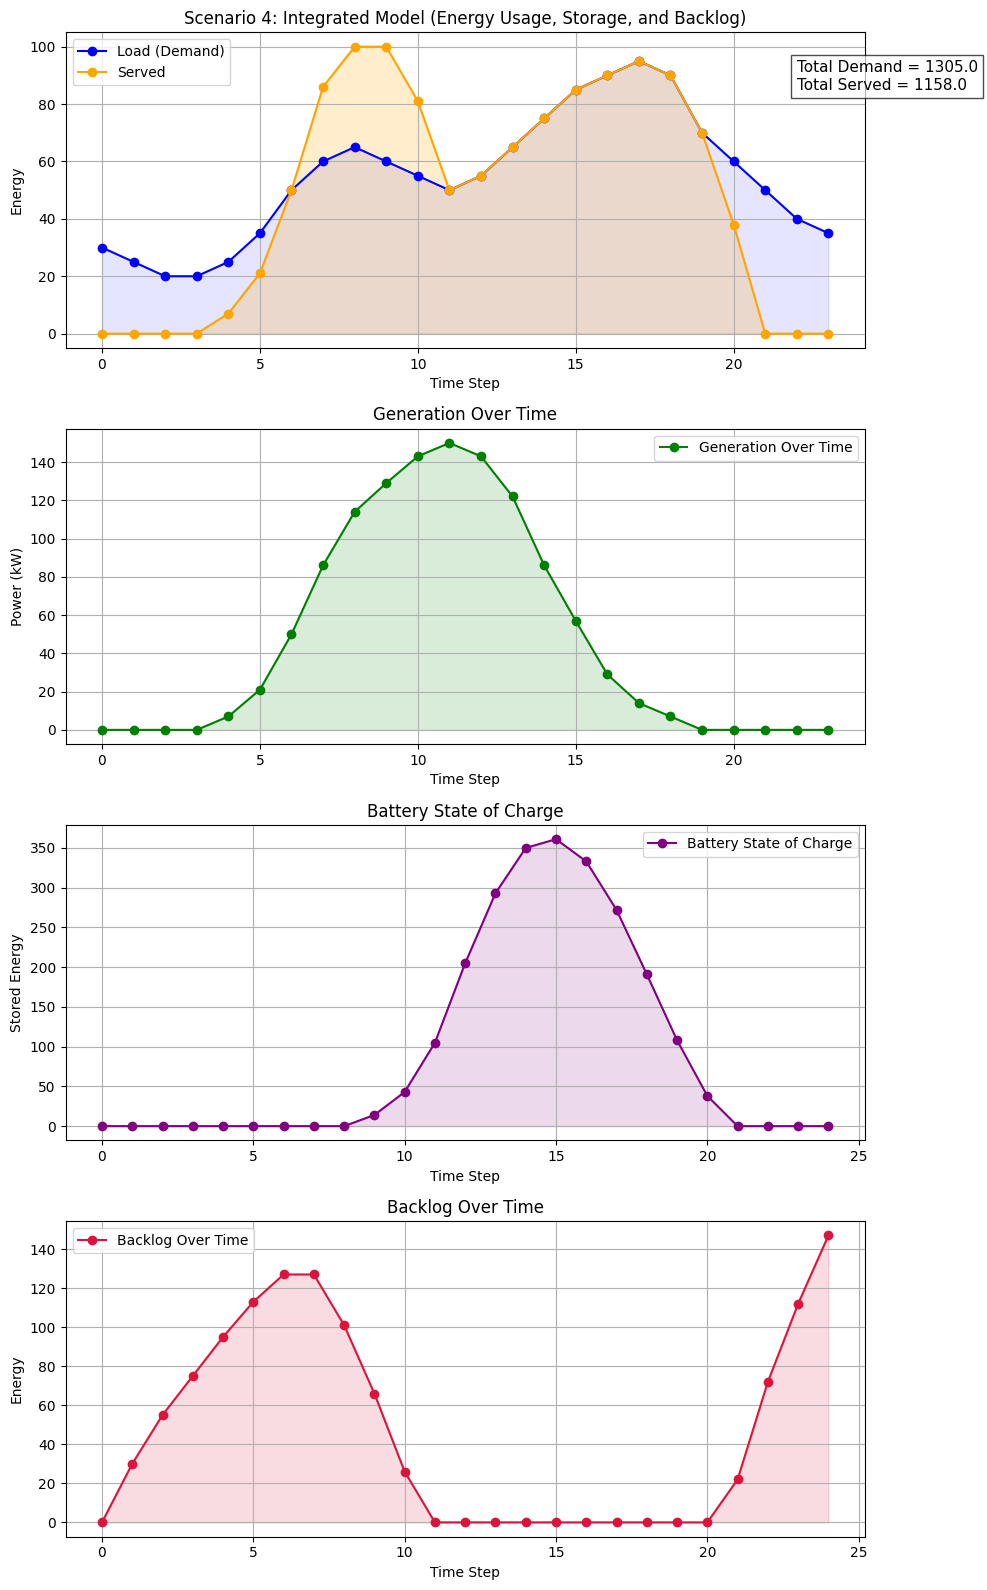

In [38]:
import gurobipy as gp
from gurobipy import GRB

# Model
m4 = gp.Model("workload_storage_scheduling_scenario_4")
m4.setParam('OutputFlag', 0)

# Decision variables
u = m4.addVars(T, name="u", lb=0)              # Energy used to meet load
s_charge = m4.addVars(T, name="s_charge", lb=0)  # Energy charged into storage
s_discharge = m4.addVars(T, name="s_discharge", lb=0)  # Energy discharged from storage
x = m4.addVars(T+1, name="x", lb=0)             # Backlog at each time step
c = m4.addVars(T+1, name="c", lb=0)             # Storage level (state of charge) at each time step

# Initial conditions
m4.addConstr(x[0] == 0, "initial_backlog")
m4.addConstr(c[0] == 0, "initial_storage")

# Dynamics and constraints
for t in range(T):
    # Energy used to meet the load (all load must be met)
    # m4.addConstr(u[t] == L[t], name=f"meet_load_{t}")
    
    # Energy balance equation: G[t] = u[t] + s_charge[t] - s_discharge[t]
    m4.addConstr(u[t] + s_charge[t] - s_discharge[t] <= G[t], name=f"energy_balance_{t}")
    
    # Update storage level: c[t+1] = c[t] + s_charge[t] - s_discharge[t]
    m4.addConstr(c[t+1] == c[t] + s_charge[t] - s_discharge[t], name=f"storage_update_{t}")
    m4.addConstr(c[t]<=battery_limit, name = "storage limit")

    
    # Backlog update: x[t+1] = x[t] + L[t] - u[t]
    m4.addConstr(x[t+1] == x[t] + L[t] - u[t], name=f"backlog_update_{t}")

    m4.addConstr(u[t] <= computing_limit, name=f"computing limit")


# Terminal conditions: no backlog and battery is empty at the end
# m4.addConstr(x[T] == 0, "terminal_backlog")
m4.addConstr(c[T] == 0, "terminal_storage")

# Objective: minimize energy use (serving load) and energy storage transitions (charging/discharging)
m4.setObjective(gp.quicksum(q * u[t] + r * (x[t]+L[t]-u[t]) for t in range(T)), GRB.MINIMIZE) # previously had cost to charge and discharged changed to cost ot backlog

# punish backlog, unmet demand
# Optimize the model
m4.optimize()

# Print results
if m4.status == GRB.OPTIMAL:
    print("\nOptimal Schedule for Scenario 4:")
    # for t in range(T):
    #     print(f"Time {t}: u={u[t].X:.2f}, s_charge={s_charge[t].X:.2f}, s_discharge={s_discharge[t].X:.2f}, x={x[t].X:.2f}, c={c[t].X:.2f}")
    # print(f"Final: x[T]={x[T].X:.2f}, c[T]={c[T].X:.2f}")
    
    # Optionally, you can also plot the results
    served_4 = [u[t].X for t in range(T)]  # Energy served to meet the load
    soc_4 = [c[t].X for t in range(T+1)]  # State of charge at each time step
    backlog_4 = [x[t].X for t in range(T+1)]  # Backlog at each time step

    plot_results("Scenario 4: Integrated Model (Energy Usage, Storage, and Backlog)", served_4, soc=soc_4, second_plot=True,backlog = backlog_4)


Deferal of elecrtricity for workload schedule, look for interesting ranges, 
Regime changes, where we switch from storage to workload to storage.
Find an analytical solution
Leave cost of load shifting as a variable,

Cost of load shifting is taken care of backlog, 

Add an innefiency to discahrge c, for analytical solution, once we have everything go through and replace with eta and make it all works. help us the regime shift between load shifting and storage. For computaiton we can leave eta as is, for charge and discharge

From this first pass on the ACDC, we can see numerically that Job scheduling and storage complement each other as hypothesized by result of solving the optimal dual variables: check notes.
Indeed, in scenario 3, where we only had storage, we had to store 488 MW, to serve 1158 MW of load. In scenario 2, where we only schedule jobs, we serve 797 had a final backlog of, 500, the sum of all backlogs at 3435 (area under the curve), and the max backlog 508.
When we combine both we are able to meet the same demand of 1158, max stored amount 361 (-127 MW), and max backlog 330 (-178), total backlog 2249 (-1200?), and final backlog of 150 (-350).
Interestingly enough, if we introduce a maximum computational ability, it doesn't change our results that much.

In both cases, we still can't meet the entire demand, which is surprising to me since total generation surpasses ask in OH, we would need to have a lot more storage and renewable production for that to happen. But we try another alternative, to incorporate the grid.

# Scenario 5 Grid - No Renewables

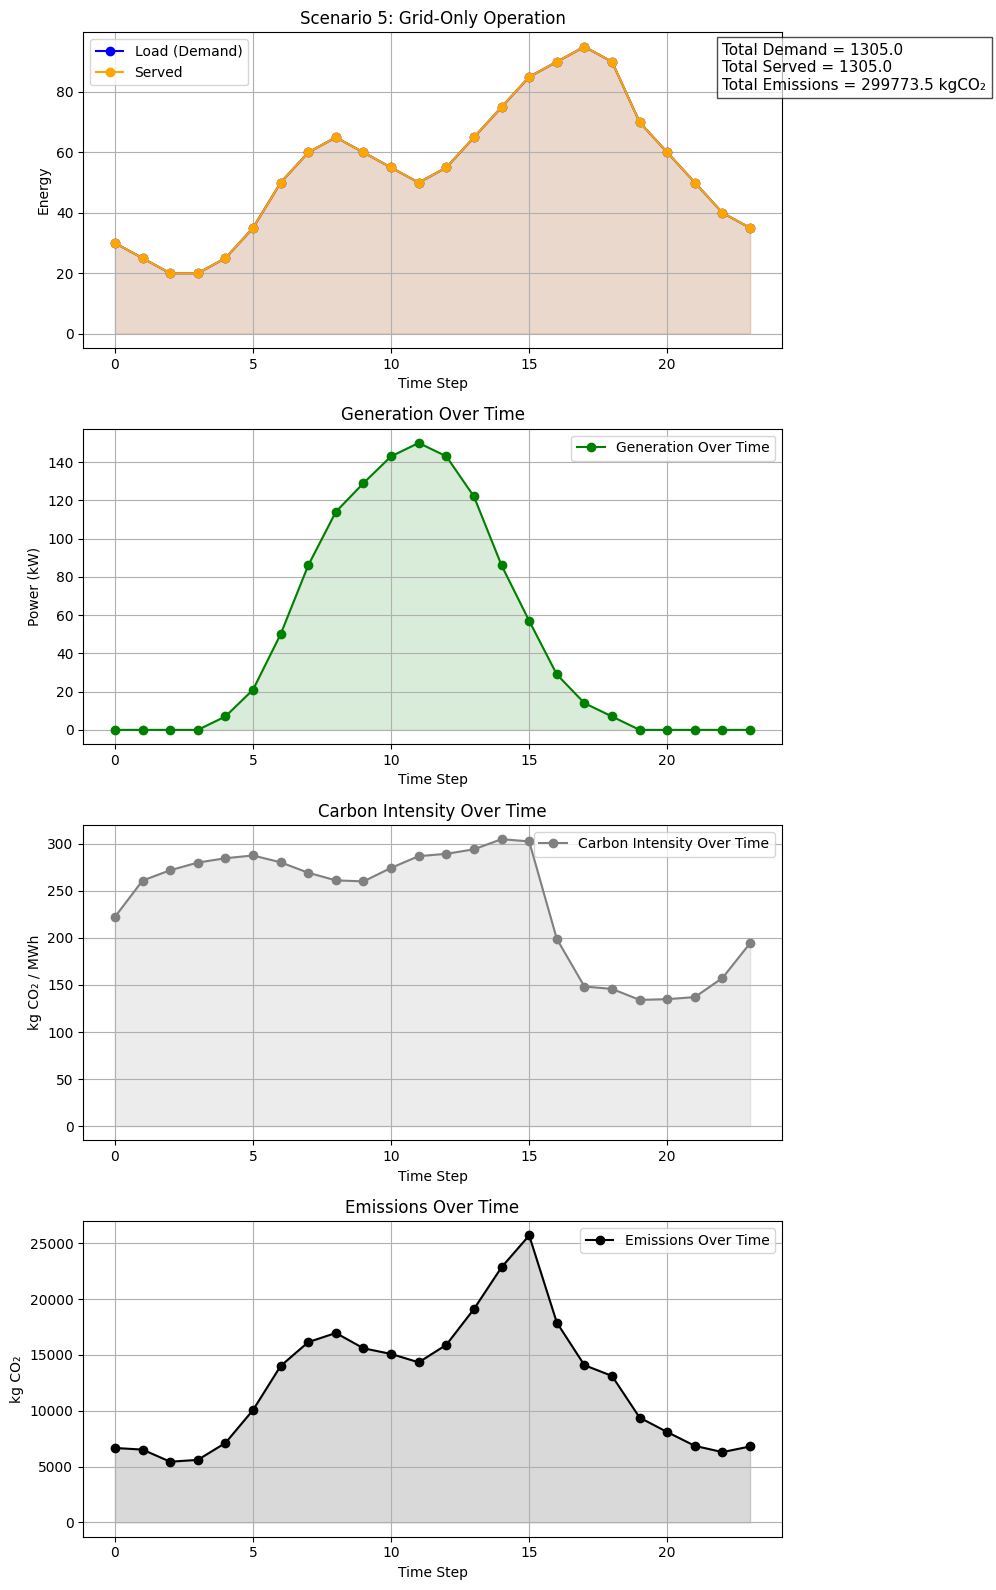

In [39]:

# Assume all demand is served by the grid
served_5 = L[:]  # copy of L, since all load is met
grid_energy = L  # all demand is met via the grid

# Calculate emissions in kgCO2 (convert gCO2/kWh to kgCO2/kWh)
emissions_5 = [grid_energy[t] * C[t] for t in range(T)]
total_emissions_5 = sum(emissions_5)

# Plot results
plot_results("Scenario 5: Grid-Only Operation", served_5, second_plot=True, carbon_intensity=C,emissions=emissions_5)




# Scenario 6 Grid + JS 

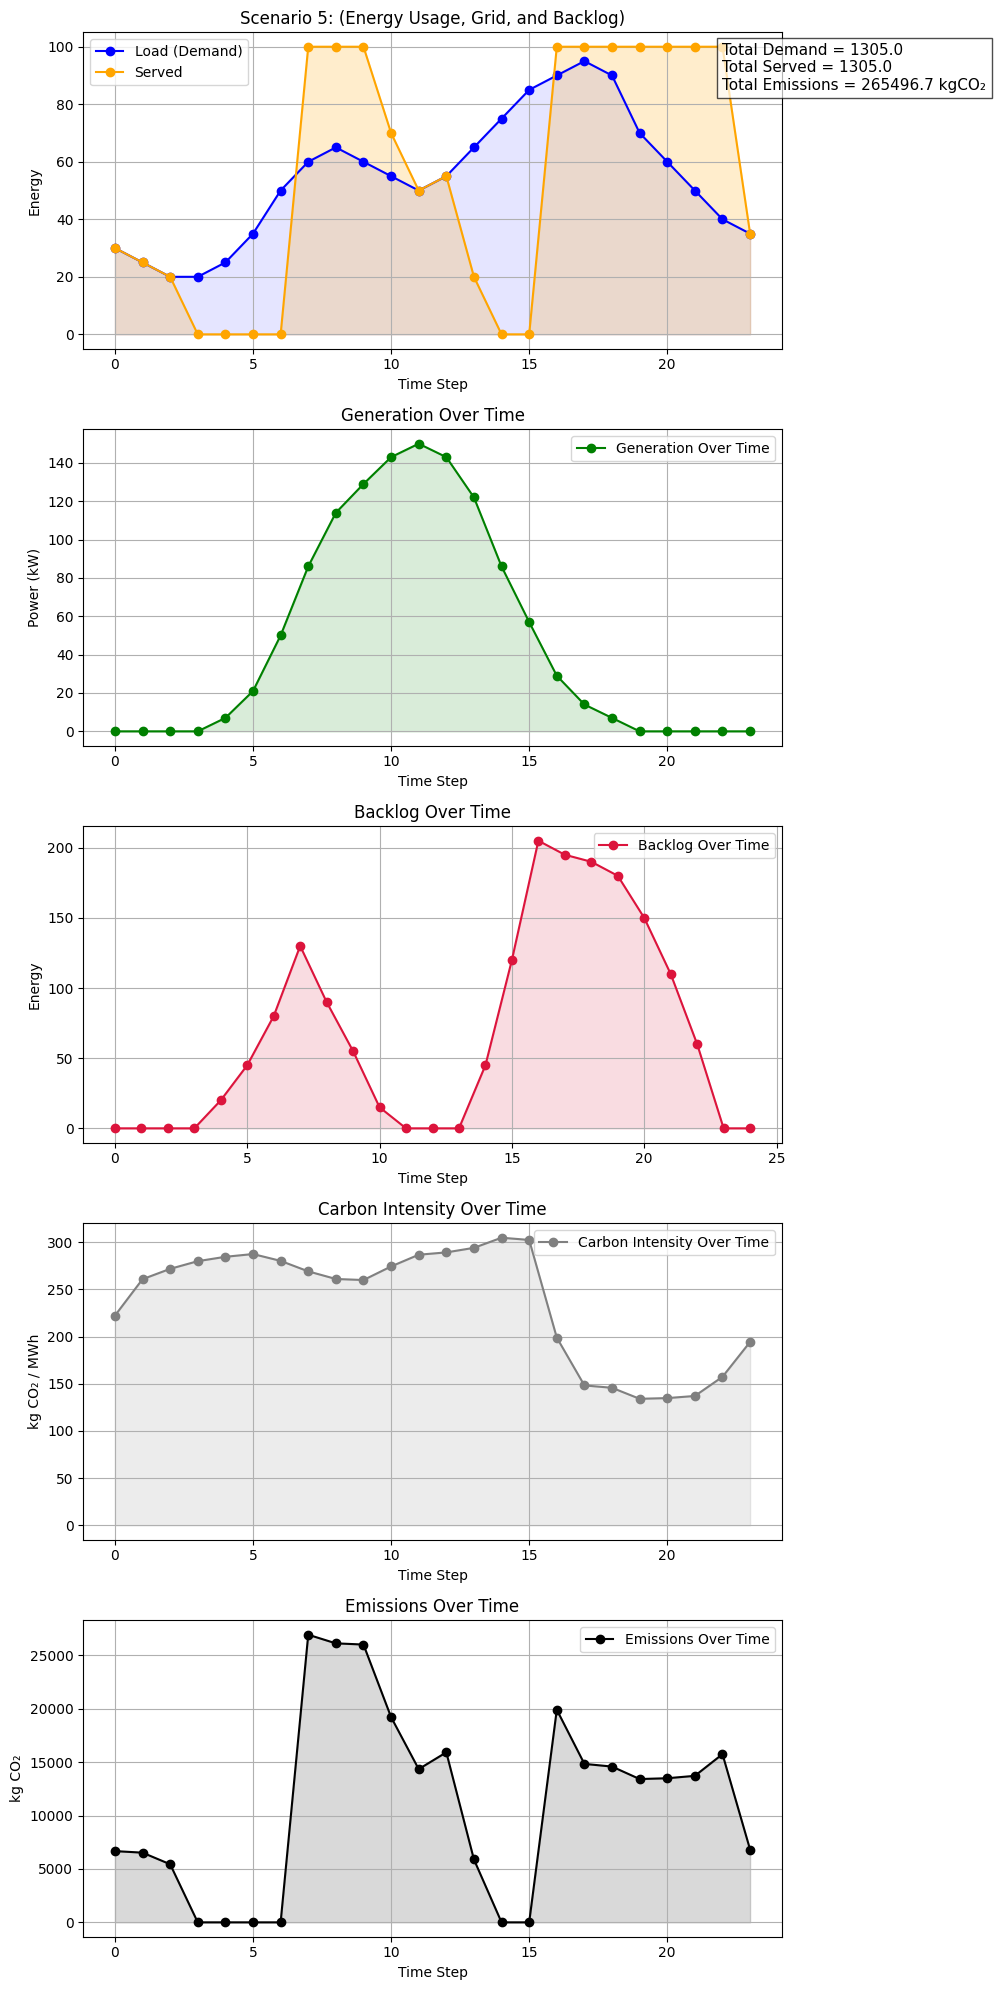

In [40]:
m5 = gp.Model("Grid optimal Scheduling")
m5.setParam("OutputFlag",0)

# Decision Variables
u = m5.addVars(T,name = "u",lb=0) #u_T computing at time t
x = m5.addVars(T+1,name="x",lb=0) # backlog
# Initial Conditions
m5.addConstr(x[t] ==0,"initial backlog")

for t in range(T):
    m5.addConstr(x[t+1] == x[t]+L[t] - u[t])
    m5.addConstr(u[t] <= computing_limit)

m5.addConstr(x[T] ==0,"terminal backlog") #ensure that all the demand is met

m5.setObjective(gp.quicksum(u[t]*C[t] for t in range(T)),GRB.MINIMIZE)

m5.optimize()

if m5.status == GRB.OPTIMAL:
    served_5 = [u[t].X for t in range(T)]  # Energy served to meet the load
    backlog_5 = [x[t].X for t in range(T+1)]  # Backlog at each time step
    emissions_5 = [u[t].X * C[t] for t in range(T)]
    plot_results("Scenario 5: (Energy Usage, Grid, and Backlog)", served_5,second_plot=True, backlog = backlog_5, carbon_intensity=C,emissions= emissions_5)


Add the Social cost of carbon, 50 dollars per ton, cost of electricity (static of dynamic)

# Scenario 7 Grid, Storage, JS, Renewables


Optimal Schedule for Scenario 4:


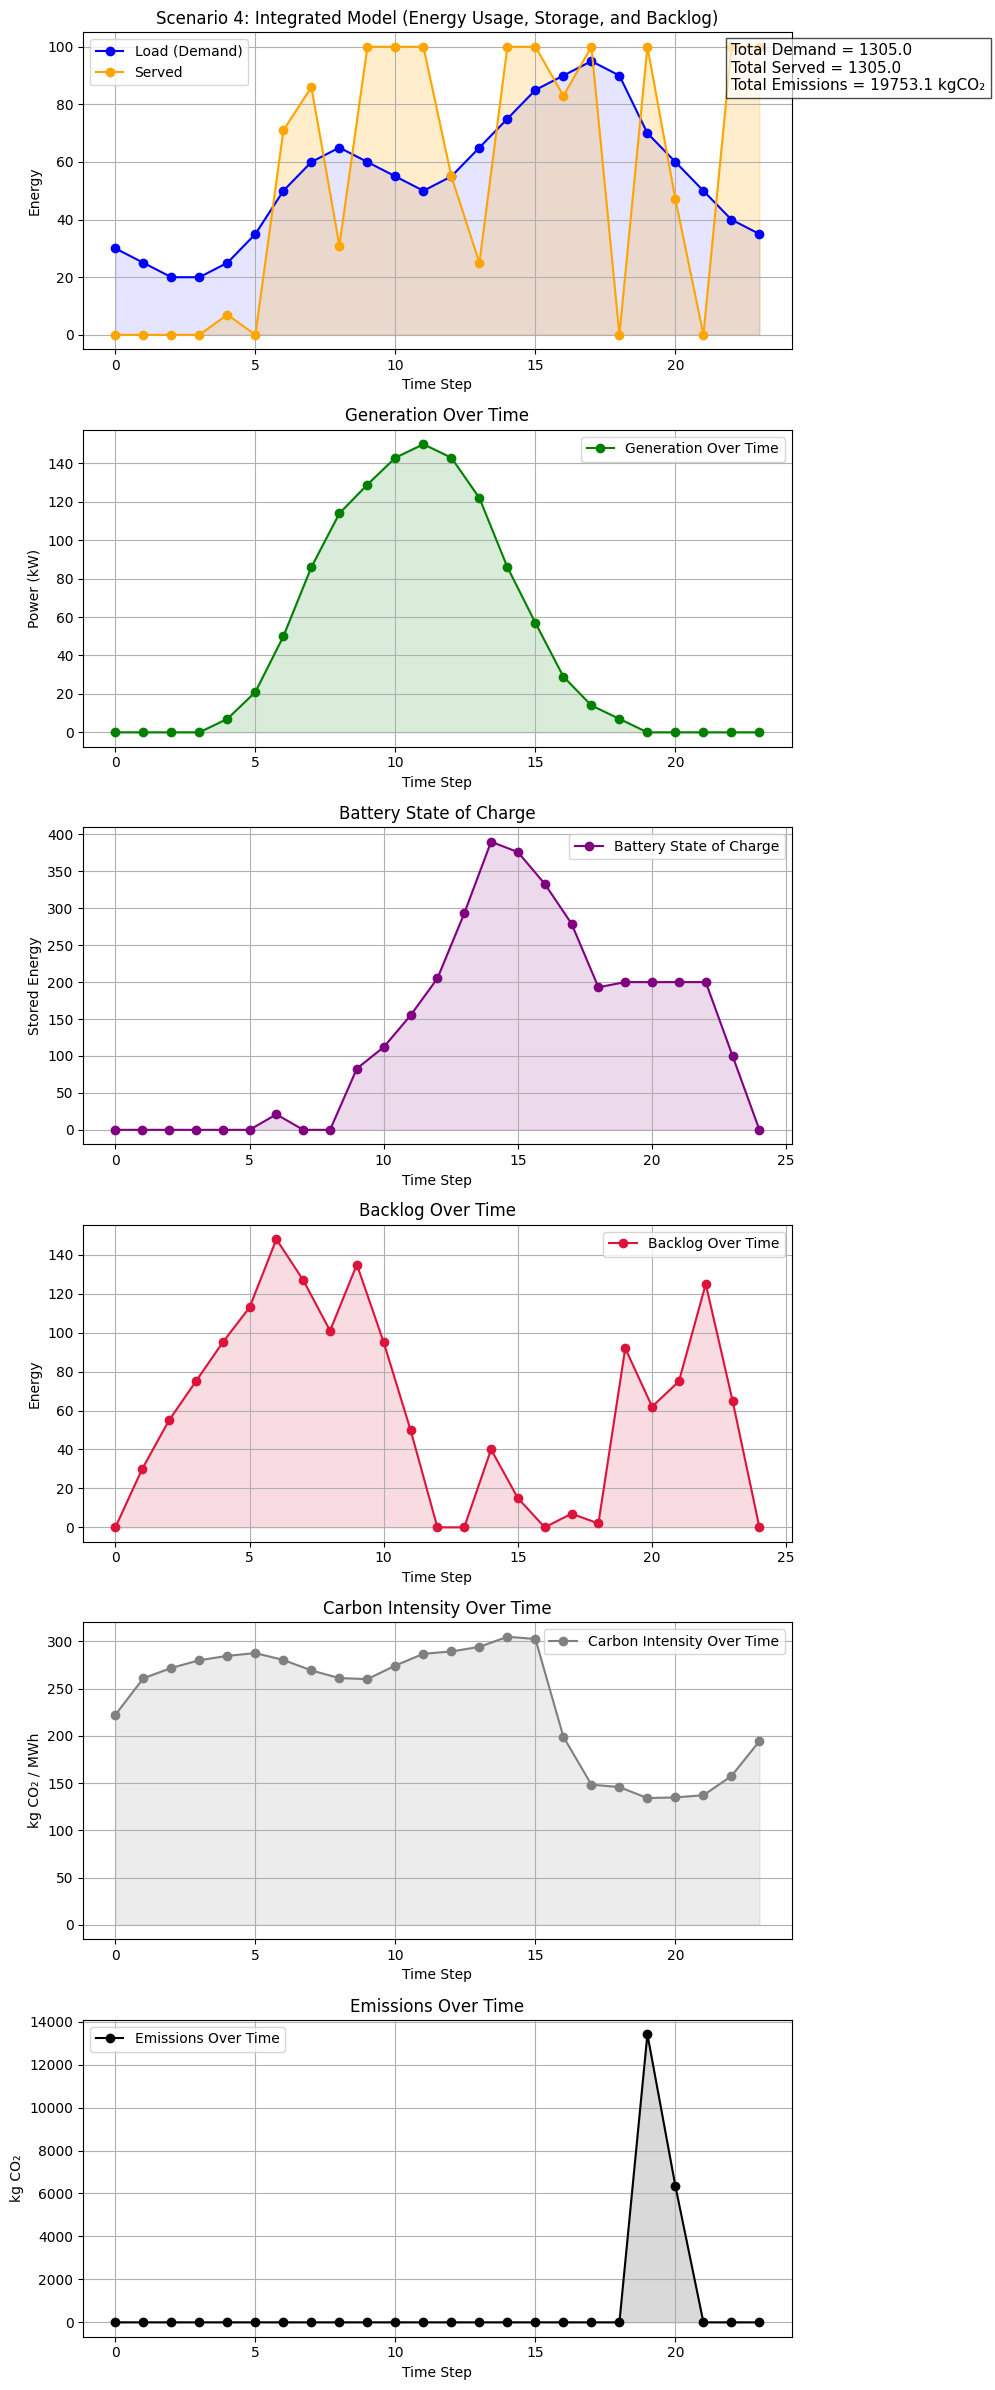

In [41]:
m7 = gp.Model("Grid + Storage + Renewables Optimal Scheduling")
m7.setParam("OutputFlag",0)

u_g = m7.addVars(T,name= "u_g",lb=0) # power associated with grid use
u_r = m7.addVars(T,name= "u_r",lb=0) # power associated with renewable use
s_charge_r = m7.addVars(T,name="s_charge_r",lb=0) # charge associated with renewables
# s_charge_g = m7.addVars(T,name="s_charge_g",lb=0) # charge associated with grid
s_discharge_r = m7.addVars(T,name="s_discharge_r",lb=0) # discharge associated with renewables
# s_discharge_g = m7.addVars(T,name="s_discharge_g",lb=0) # discharge associated with grid
x = m7.addVars(T+1,name="x",lb=0) # Backlog
c = m7.addVars(T+1,name="c",lb=0) #SoC

#Initial Conditions
m7.addConstr(x[0]==0,"initial backlog")
m7.addConstr(c[0]==0,"inital storage")

for t in range(T):
    m7.addConstr(u_r[t]+s_charge_r[t]-s_discharge_r[t]==G[t])
    m7.addConstr(c[t+1] == c[t] + s_charge_r[t] - s_discharge_r[t])
    m7.addConstr(c[t]<=battery_limit, name = "storage limit")
    m7.addConstr(x[t+1] == x[t] + L[t] - u_g[t]-u_r[t])
    m7.addConstr(u_g[t]+u_r[t]<= computing_limit)

m7.addConstr(x[T] == 0, "terminal_backlog")
m7.addConstr(c[T] == 0, "terminal_storage")

m7.setObjective(gp.quicksum(u_g[t]*C[t] for t in range(T)), GRB.MINIMIZE)

# Optimize the model
m7.optimize()

if m7.status == GRB.OPTIMAL:
    print("\nOptimal Schedule for Scenario 4:")
    # for t in range(T):
    #     print(f"Time {t}: u={u[t].X:.2f}, s_charge={s_charge[t].X:.2f}, s_discharge={s_discharge[t].X:.2f}, x={x[t].X:.2f}, c={c[t].X:.2f}")
    # print(f"Final: x[T]={x[T].X:.2f}, c[T]={c[T].X:.2f}")
    
    # Optionally, you can also plot the results
    served_7 = [u_g[t].X + u_r[t].X for t in range(T)]  # Energy served to meet the load
    soc_7 = [c[t].X for t in range(T+1)]  # State of charge at each time step
    backlog_7 = [x[t].X for t in range(T+1)]  # Backlog at each time step
    emissions_7 = [u_g[t].X * C[t] for t in range(T)]

    plot_results("Scenario 4: Integrated Model (Energy Usage, Storage, and Backlog)", served_7, soc=soc_7, second_plot=True,backlog = backlog_7, carbon_intensity=C, emissions=emissions_7)





Although we were able to meet all of the demand, perhaps we would have been able to reduce costs further 

# Scenario 8  Cooling and normal generation

We assume that all electricity used for computing purposes is generated into heat, and the heat removed/cooled is the same as the heat generated:

$$
\dot{Q}_{load} = \dot{W}_{computing} = \dot{Q}_{cooling}
$$

Thus, 
$$
P_{chiller}(t) = \frac{\dot{Q}_{cooling}(t)}{COP(T_{ambient}(t))}
$$

From literature (Yu 2005 and Zhang 2024), we determine a relationship between COP and ambient temperature:
$$
COP(T_{ambient}(t)) = COP_{ref} \cdot (1-0.02(T_{ambient} - T_{ref}))
$$

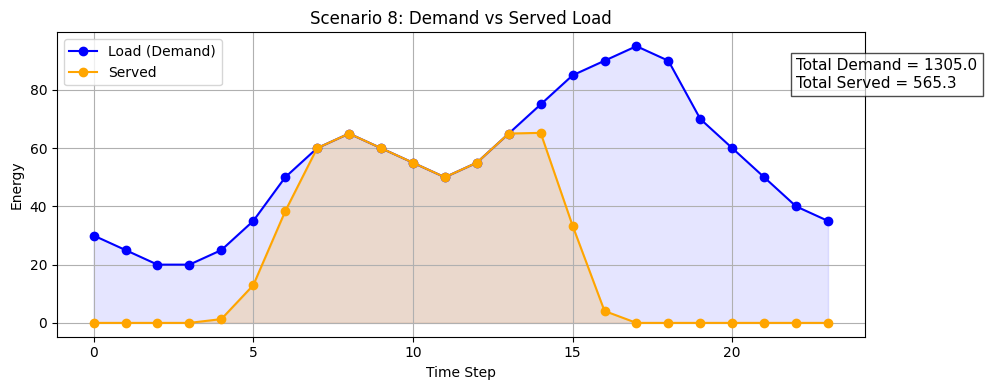

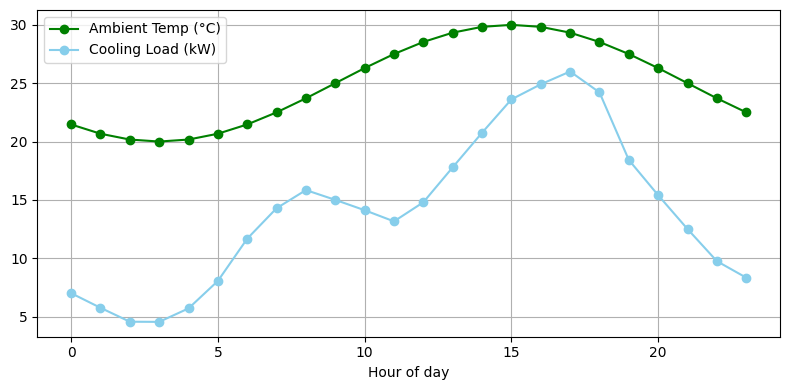

In [42]:
import numpy as np
import matplotlib.pyplot as plt


hours = np.arange(len(L))
T = len(L)
T_ref, COP_ref = 25.0, 4.0
T_amb = T_ref + 5.0 * np.cos((hours - 15)/24 * 2*np.pi)
COP = COP_ref * (1.0 - 0.02 * (T_amb - T_ref))

# 2) cooling electric draw (kW)
P_chiller = L / COP

net_gen = G - P_chiller

# correct served load (list comprehension)
served_8 = [min(L[t], net_gen[t]) for t in range(T)]

# — or, even better, use numpy:
served_8 = np.minimum(L, np.clip(net_gen, 0, None))


# 3) total load served = IT + cooling
served_8  = np.minimum(L, np.clip(net_gen, 0, None))


# Demand vs. Served Load
plot_results("Scenario 8: Demand vs Served Load", served_8)

# Ambient Temperature and Cooling Load
plt.figure(figsize=(8,4))
plt.plot(range(len(L)), T_amb,       marker='o', label="Ambient Temp (°C)", color="green")
plt.plot(range(len(L)), P_chiller,   marker='o', label="Cooling Load (kW)", color="skyblue")
plt.xlabel("Hour of day")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()






# Scenario 9 Cooling and JS

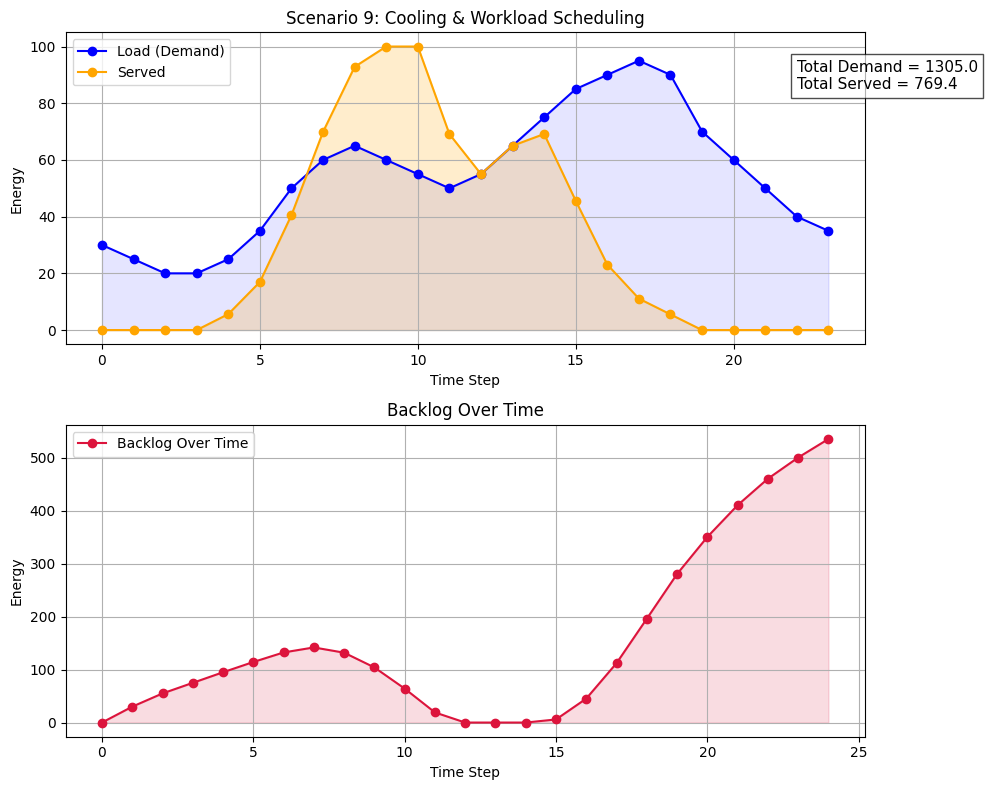

In [47]:
hours = np.arange(T)             
T_ref, COP_ref = 25.0, 4.0
T_amb = T_ref + 5.0 * np.sin((hours - 15)/24 * 2*np.pi)
COP   = COP_ref * (1.0 - 0.02 * (T_amb - T_ref))

# Model
m9 = gp.Model("cooling_workload_scheduling_no_storage")
m9.setParam('OutputFlag', 0)

# Decision variables
u = m9.addVars(T, name="u", lb=0)        # Computing energy used
x = m9.addVars(T+1, name="x", lb=0)      # Backlog
P_chiller = m9.addVars(hours, lb=0, name="P_chiller")

# Initial condition
m9.addConstr(x[0] == 0, "initial_backlog")

# Dynamics and constraints
for t in range(T):
    m9.addConstr(x[t+1] == x[t] + L[t] - u[t], name=f"backlog_update_{t}")
    m9.addConstr(u[t] <= computing_limit, name=f"computing limit")
    m9.addConstr((u[t] + P_chiller[t] <= G[t]), name=f"power_balance_{t}")
    m9.addConstr((COP[t] * P_chiller[t] >= u[t]), name=f"cooling_req_{t}")


# Terminal condition
m9.addConstr(x[T] >= 0, "terminal_backlog")

# Objective: Minimize backlog and energy cost (no energy term bc only renewables)
m9.setObjective(gp.quicksum(r * x[t] for t in range(T+1)), GRB.MINIMIZE)

# Optimize
m9.optimize()

# Extract and plot results
if m9.status == GRB.OPTIMAL:
    served_9 = [u[t].X for t in range(T)]
    backlog_9 = [x[t].X for t in range(T+1)]  # Backlog at each time step
    plot_results("Scenario 9: Cooling & Workload Scheduling", served_9, second_plot=None, backlog=backlog_9)
    
if m9.status != GRB.OPTIMAL:
    print("Optimization failed or was not optimal.")



# Scenario 10 Cooling, JS, Storage


Optimal Schedule for Scenario 4:


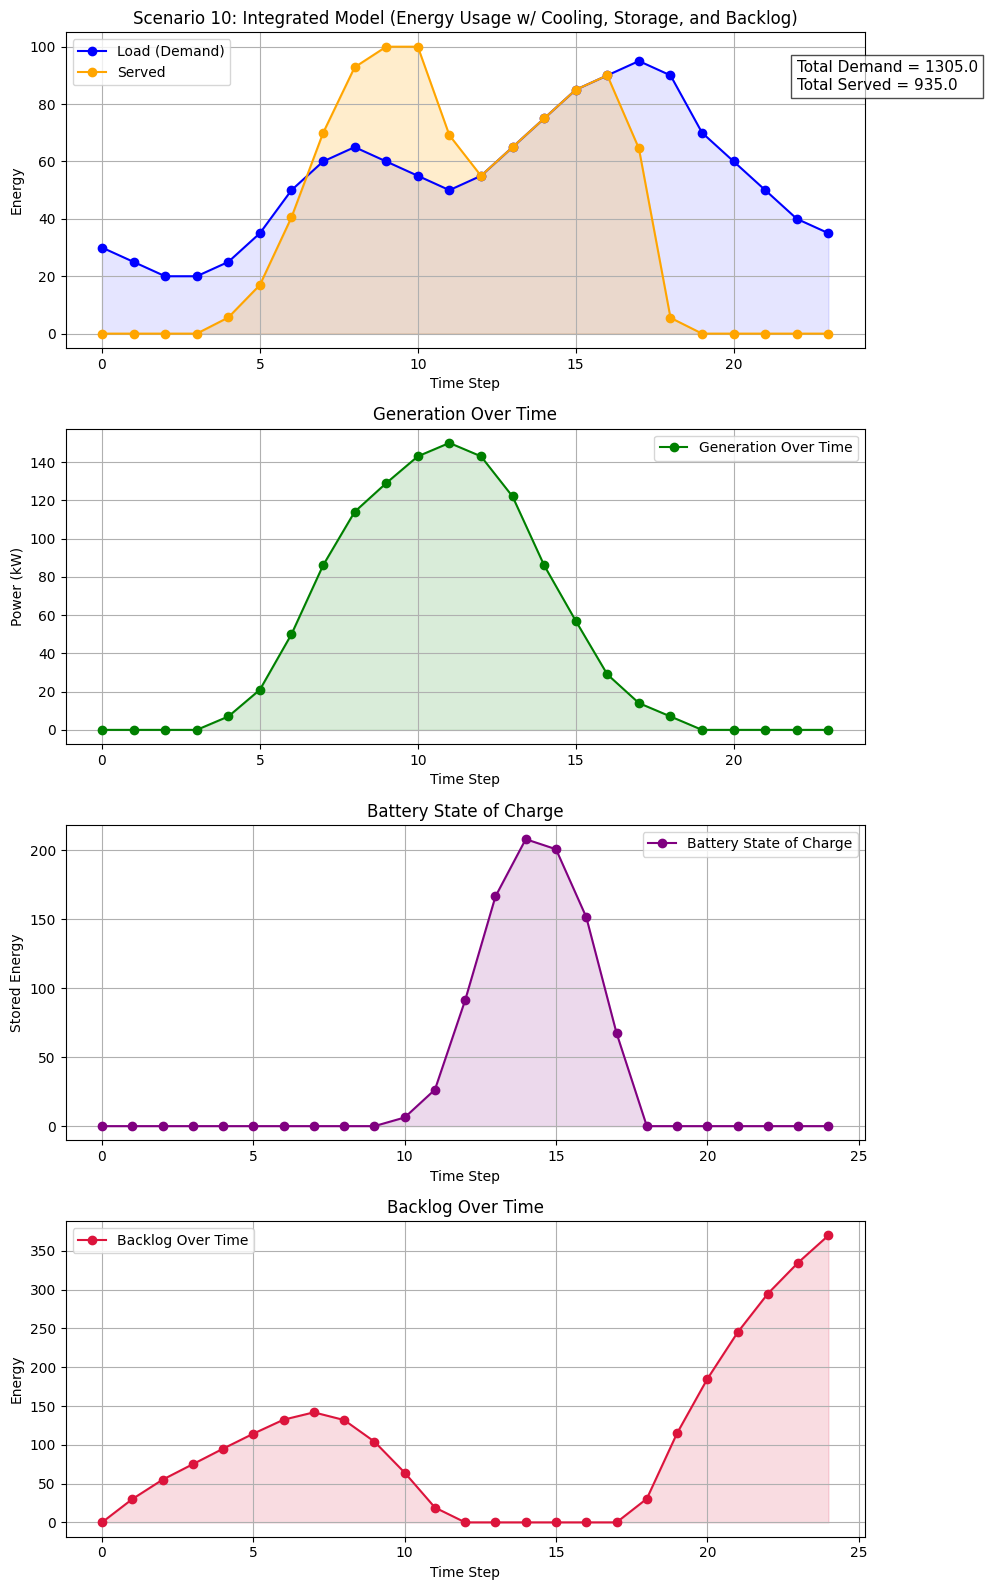

In [48]:
import gurobipy as gp
from gurobipy import GRB

# Model
m10 = gp.Model("workload_storage_scheduling_scenario_4")
m10.setParam('OutputFlag', 0)

# Decision variables
u = m10.addVars(T, name="u", lb=0)              # Energy used to meet load
s_charge = m10.addVars(T, name="s_charge", lb=0)  # Energy charged into storage
s_discharge = m10.addVars(T, name="s_discharge", lb=0)  # Energy discharged from storage
x = m10.addVars(T+1, name="x", lb=0)             # Backlog at each time step
c = m10.addVars(T+1, name="c", lb=0)             # Storage level (state of charge) at each time step
P_chiller = m10.addVars(T, lb=0, name="P_chiller")

# Initial conditions
m10.addConstr(x[0] == 0, "initial_backlog")
m10.addConstr(c[0] == 0, "initial_storage")

# Dynamics and constraints
for t in range(T):
    
    m10.addConstr(u[t] + P_chiller[t] + s_charge[t] - s_discharge[t] <= G[t], name=f"energy_balance_{t}")
    m10.addConstr(c[t+1] == c[t] + s_charge[t] - s_discharge[t], name=f"storage_update_{t}")
    m10.addConstr(c[t]<=battery_limit, name = "storage limit")
    m10.addConstr(x[t+1] == x[t] + L[t] - u[t], name=f"backlog_update_{t}")
    m10.addConstr(u[t] <= computing_limit, name=f"computing limit")
    m10.addConstr((COP[t] * P_chiller[t] >= u[t]), name=f"cooling_req_{t}")


# Terminal conditions: no backlog and battery is empty at the end
m10.addConstr(c[T] == 0, "terminal_storage")

# Objective: minimize energy use (serving load) and energy storage transitions (charging/discharging)
m10.setObjective(gp.quicksum(q * u[t] + r * (x[t]+L[t]-u[t]) for t in range(T)), GRB.MINIMIZE) # previously had cost to charge and discharged changed to cost ot backlog

# punish backlog, unmet demand
# Optimize the model
m10.optimize()

# Print results
if m10.status == GRB.OPTIMAL:
    print("\nOptimal Schedule for Scenario 4:")
    # for t in range(T):
    #     print(f"Time {t}: u={u[t].X:.2f}, s_charge={s_charge[t].X:.2f}, s_discharge={s_discharge[t].X:.2f}, x={x[t].X:.2f}, c={c[t].X:.2f}")
    # print(f"Final: x[T]={x[T].X:.2f}, c[T]={c[T].X:.2f}")
    
    # Optionally, you can also plot the results
    served_10 = [u[t].X for t in range(T)]  # Energy served to meet the load
    soc_10 = [c[t].X for t in range(T+1)]  # State of charge at each time step
    backlog_10 = [x[t].X for t in range(T+1)]  # Backlog at each time step

    plot_results("Scenario 10: Integrated Model (Energy Usage w/ Cooling, Storage, and Backlog)", served_10, soc=soc_10, second_plot=True,backlog = backlog_10)


# Scenario 11 Grid + Cooling + Storage + JS 

Draw from the grid at noon (or other low carbon intensity times) to compute stuff, store energy at the same time. Then at night, discharge and compute, while ambient temperature is low, and carbon grid intensity is higher. Backlog tasks need to start at the same point and end at the same point.


Optimal Schedule for Scenario 11:


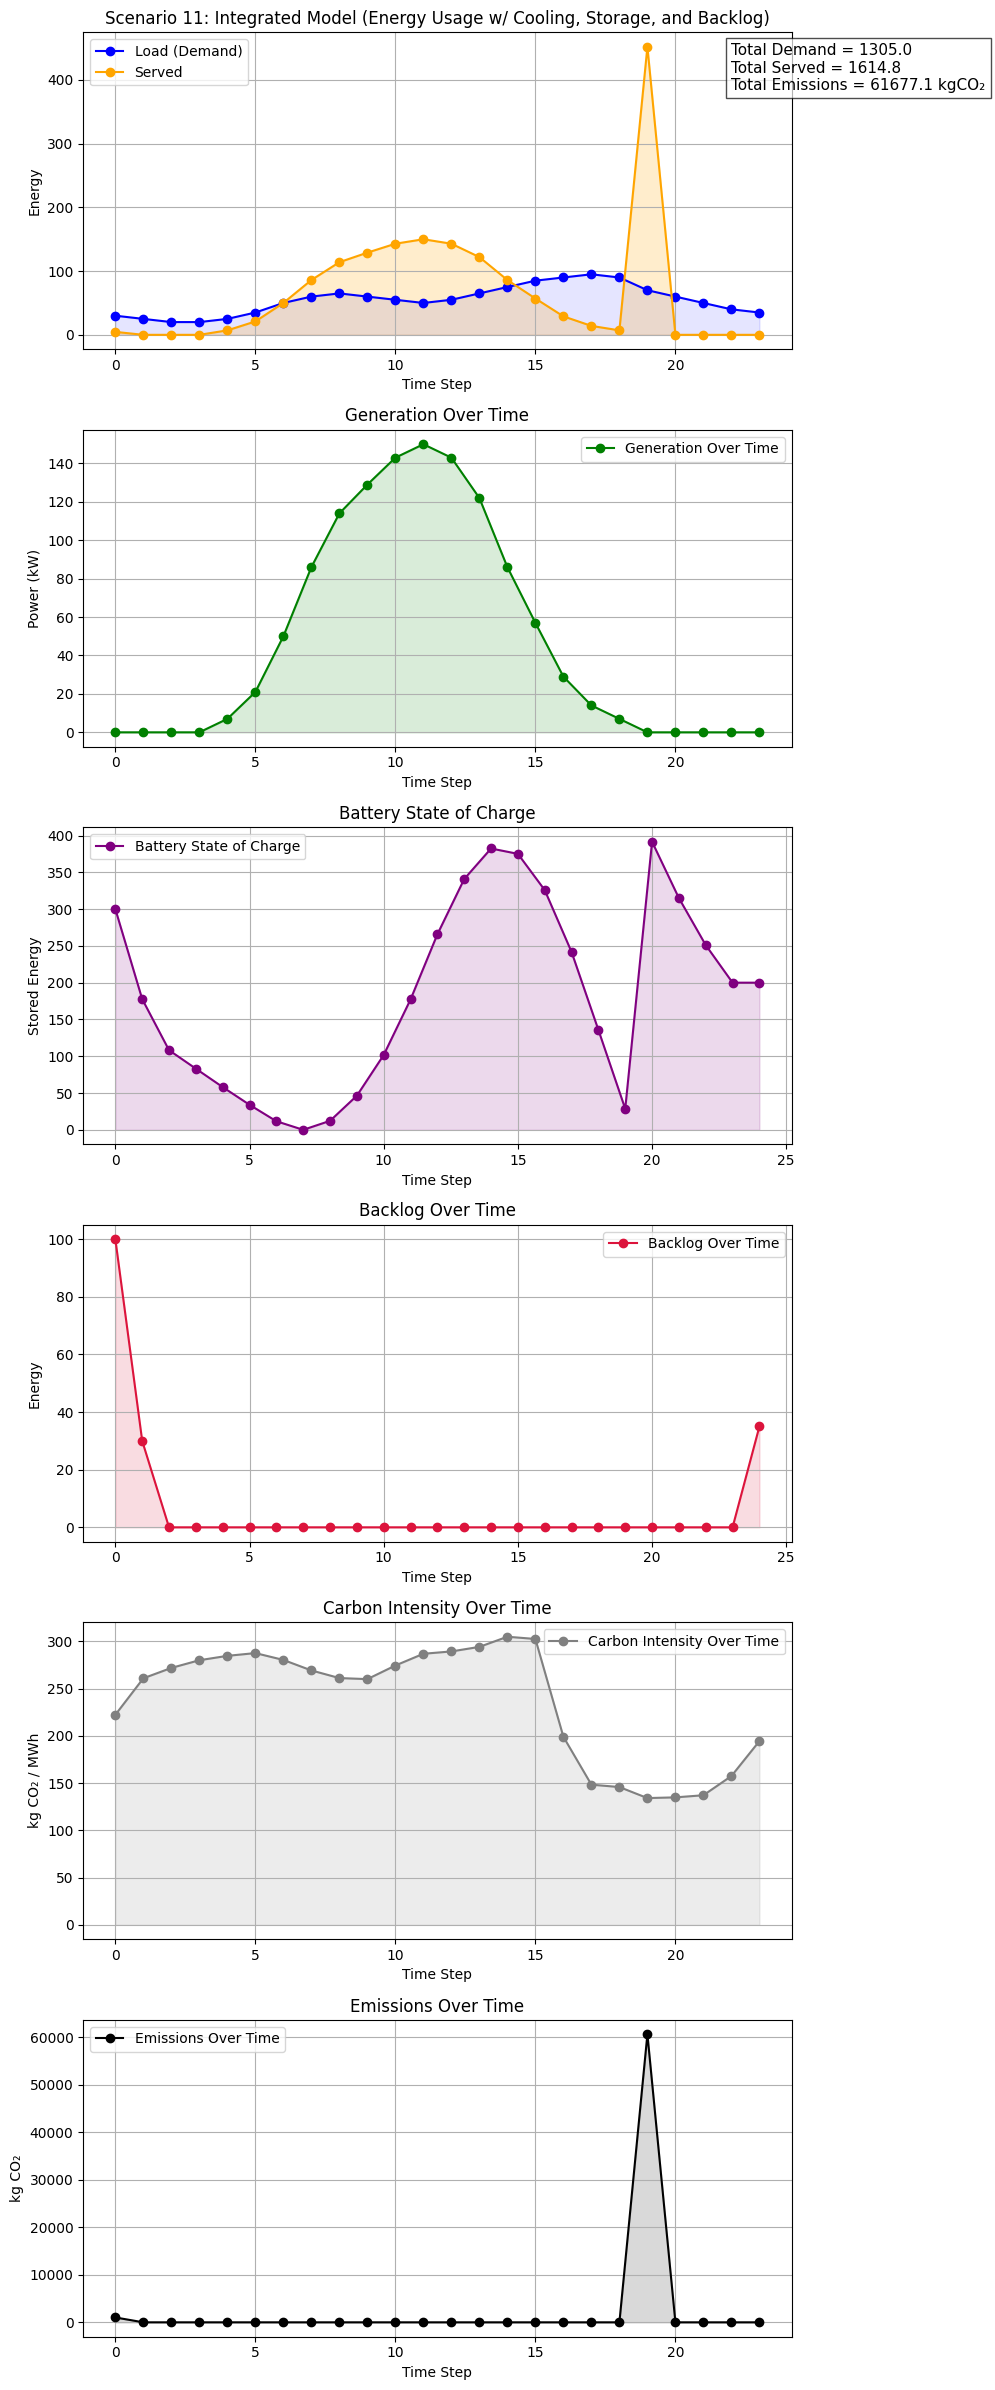

In [77]:
# Parameters
q = 1.0  # Cost per unit energy used
r = 200  # Cost per unit backlog
k = 1  # Storage energy conversion factor
computing_limit =100 # float("inf") #or switch to actual computing limit
battery_limit = 1000 # float("inf") # or switch to actual computing limit
# Generation (G_t) over 10 time steps (e.g., hours of the day)
# G = [30, 40, 50, 60, 75, 90, 100, 80, 60, 40]  # Peak generation occurs midday and early evening

# # Load (L_t) over the same 10 time steps
# L = [35, 45, 50, 55, 70, 85, 90, 80, 65, 40]  # Load peaks during evening hours
L = [
    30, 25, 20, 20, 25, 35, 50, 60, 65, 60, 55, 50, 
    55, 65, 75, 85, 90, 95, 90, 70, 60, 50, 40, 35
]  # Computational Load sum = 1400
G = [
     0, 0, 0, 0, 7, 21, 50, 86, 114, 129, 143, 150,
   143, 122, 86, 57, 29, 14, 7, 0, 0, 0, 0, 0
]  #Renewable Generation sum = 1526

T = len(G)


C = Carbon_intensity[:T]  # Carbon intensity in gCO2/kWh

m11 = gp.Model("Cooling + Grid + Storage + Renewables Optimal Scheduling")
m11.setParam("OutputFlag",0)

u_g = m11.addVars(T,name= "u_g",lb=0) # power associated with grid use
u_r = m11.addVars(T,name= "u_r",lb=0) # power associated with renewable use
s_charge_r = m11.addVars(T,name="s_charge_r",lb=0) # charge associated with renewables
s_charge_g = m11.addVars(T,name="s_charge_g",lb=0) # charge associated with grid
s_discharge = m11.addVars(T,name="s_discharge",lb=0) # discharge of battery, not associated with grid or renewables
x = m11.addVars(T+1,name="x",lb=0) # Backlog
c = m11.addVars(T+1,name="c",lb=0) #SoC
P_chiller = m11.addVars(T, name="P_chiller", lb=0) # cooling load
u = m11.addVars(T, name="u", lb=0) # computing load


#Initial Conditions
m11.addConstr(x[0]==100,"initial backlog")
m11.addConstr(c[0]==300,"inital storage")

#Terminal Conditions
m11.addConstr(c[T] >= 200, "terminal_storage")
m11.addConstr(x[T] <= x[0], "terminal_backlog") 

# Dynamics and constraints
m11.addConstrs((c[t+1] == c[t] + s_charge_r[t] + s_charge_g[t] - s_discharge[t] for t in range(T)), name="soc_update")
m11.addConstrs((c[t+1] <= battery_limit for t in range(T)), name="storage_capacity")
m11.addConstrs((s_discharge[t] <= c[t] for t in range(T)), name="max_discharge")
m11.addConstrs((x[t+1] == x[t] + L[t] - u[t] for t in range(T)), name="backlog_update")
m11.addConstrs((u[t] <= computing_limit for t in range(T)),name="compute_limit")
m11.addConstrs((COP[t]*P_chiller[t] >= u[t] for t in range(T)),name="cooling_req")
m11.addConstrs((u_r[t] + s_charge_r[t] == G[t] for t in range(T)),name="renewables_balance")
m11.addConstrs((u_g[t] + u_r[t] + s_discharge[t] == u[t] + P_chiller[t] + s_charge_r[t] + s_charge_g[t] for t in range(T)), name="energy_balance")




m11.setObjective(gp.quicksum(u_g[t]*C[t] + r*x[t] for t in range(T)), GRB.MINIMIZE)
m11.optimize()


if m11.status == GRB.OPTIMAL:
    print("\nOptimal Schedule for Scenario 11:")
    # for t in range(T):
    #     print(f"Time {t}: u={u[t].X:.2f}, s_charge={s_charge[t].X:.2f}, s_discharge={s_discharge[t].X:.2f}, x={x[t].X:.2f}, c={c[t].X:.2f}")
    # print(f"Final: x[T]={x[T].X:.2f}, c[T]={c[T].X:.2f}")
    
    served_11 = [u_g[t].X + u_r[t].X for t in range(T)]  # Energy served to meet the load
    soc_11 = [c[t].X for t in range(T+1)]  # State of charge at each time step
    backlog_11 = [x[t].X for t in range(T+1)]  # Backlog at each time step
    emissions_11 = [u_g[t].X * C[t] for t in range(T)]

    plot_results("Scenario 11: Integrated Model (Energy Usage w/ Cooling, Storage, and Backlog)", served_11, soc=soc_11, second_plot=True,backlog = backlog_11, carbon_intensity=C, emissions=emissions_11)





# Final implementation (multiday/ full year simulation babyyyyy)

According to NREL's ATB (Annual Technology Baseline) https://atb.nrel.gov/electricity/2024/land-based_wind or check Trent's data set
- CAPEX Solar = $1482/KWh
- CAPEX Wind = $1665/KWh
- CAPEX Storage = $2100/KWh 
- Neglecting O&M (Operation and Maintenance)
- Efficiency factors can be found on the same website as well.


# Scenario 12 WHR (if time allows)